In [44]:
import numpy as np
import pandas as pd
from scipy.io import wavfile, loadmat
import matplotlib.pyplot as plt


DATASET_PATH = r"DREGON/free-flight_whitenoise-high_room1" 

# Base filename prefix (without extension)
BASE_FILENAME = r"DREGON_free-flight_whitenoise-high_room1"

AUDIO_WAV_FILE = f"{DATASET_PATH}/{BASE_FILENAME}.wav"
AUDIO_TS_MAT_FILE = f"{DATASET_PATH}/{BASE_FILENAME}_audiots.mat"
IMU_MAT_FILE = f"{DATASET_PATH}/{BASE_FILENAME}_imu.mat"
SOURCE_POS_MAT_FILE = f"{DATASET_PATH}/{BASE_FILENAME}_sourcepos.mat"
MOTORS_MAT_FILE = f"{DATASET_PATH}/{BASE_FILENAME}_motors.mat" # Optional to load


In [45]:
import scipy.io as sio

audio_ts_data = sio.loadmat(AUDIO_TS_MAT_FILE)['audio_timestamps']
imu_data = sio.loadmat(IMU_MAT_FILE)['imu'][0][0] #dtype=[('timestamps', 'O'), ('angular_velocity', 'O'), ('acceleration', 'O')]
source_pos_data = sio.loadmat(SOURCE_POS_MAT_FILE)['source_position'][0][0] #dtype=[('timestamps', 'O'), ('azimuth', 'O'), ('elevation', 'O'), ('distance', 'O')]
motors_data = sio.loadmat(MOTORS_MAT_FILE)['motor'][0][0] #[('command', 'O'), ('measured', 'O'), ('timestamps', 'O')]


motors_data_r = motors_data.copy()
motors_data_r[0] = motors_data[2]
motors_data_r[1] = motors_data[0]
motors_data_r[2] = motors_data[1]

In [46]:
import scipy.io.wavfile as wav

sample_rate, audio_data = wav.read(AUDIO_WAV_FILE)

print(f"Sample Rate: {sample_rate} Hz")
print(f"Audio Data Shape: {audio_data.shape}")
print(f"Data Type: {audio_data.dtype}")

Sample Rate: 44100 Hz
Audio Data Shape: (2668292, 8)
Data Type: int32


In [ ]:
from scipy.signal import stft
def compute_multichannel_spectrogram(audio, sample_rate=48000, n_fft=1024, hop_size=512):
    from scipy.signal import stft
    # audio: [channels, samples]
    specs = []
    for ch in audio:
        f, t, Zxx = stft(ch, fs=sample_rate, nperseg=n_fft, noverlap=n_fft - hop_size)
        specs.append(np.abs(Zxx))
    # specs: [channels, freq, time] -> transpose to [time, channels, freq]
    return np.stack(specs, axis=0).transpose(2, 0, 1)  # [time, channels, freq]


In [48]:
spectrogram = compute_multichannel_spectrogram(audio_data, sample_rate)

In [49]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class DREGONAudioDataset(torch.utils.data.Dataset):
    def __init__(self, spectrogram, doa_labels):
        """
        Args:
            spectrogram: np.array of shape (freq_bins, time_frames, channels)
            doa_labels: np.array of shape (time_frames, 3) [azimuth_deg, elevation_deg, distance]
        """
        # Transpose spectrogram to (time, channels, freq)
        self.spectrogram = spectrogram.transpose(1, 2, 0)  # [T, C, F]
        self.unit_vectors = self._angles_to_unit_vector(doa_labels[:, 0], doa_labels[:, 1])  # [T, 3]

    def __len__(self):
        return self.spectrogram.shape[0]

    def __getitem__(self, idx):
        x = torch.tensor(self.spectrogram[idx], dtype=torch.float32).unsqueeze(-1)  # [C, F, 1]
        y = torch.tensor(self.unit_vectors[idx], dtype=torch.float32)  # [3]
        return x, y

    @staticmethod
    def _angles_to_unit_vector(azimuth_deg, elevation_deg):
        az = np.deg2rad(azimuth_deg)
        el = np.deg2rad(elevation_deg)
        x = np.cos(el) * np.cos(az)
        y = np.cos(el) * np.sin(az)
        z = np.sin(el)
        return np.stack([x, y, z], axis=1)


In [50]:
class DoANet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),  # 8 mic channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),  # Avoid pooling time dim
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Compress to [B, 32, 1, 1]
        )
        self.fc = nn.Linear(32, 3)  # Output x, y, z

    def forward(self, x):
        x = self.net(x)  # [B, 32, 1, 1]
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [51]:
source_ts = source_pos_data['timestamps'].squeeze()
azimuth = source_pos_data['azimuth'].squeeze()
elevation = source_pos_data['elevation'].squeeze()
distance = source_pos_data['distance'].squeeze()

In [52]:
audio_ts_data

array([[1.51967146e+09],
       [1.51967146e+09],
       [1.51967146e+09],
       ...,
       [1.51967152e+09],
       [1.51967152e+09],
       [1.51967152e+09]], shape=(2668292, 1))

In [ ]:
hop_size = 512  # Make sure this matches your STFT
# Step 1: Just use the first audio timestamp
start_time = float(audio_ts_data[0])  # one float, not whole array

# Step 2: Get total number of spectrogram frames (time axis length)
num_frames = spectrogram.shape[1]


# Step 3: Compute timestamp for each spectrogram frame
frame_timestamps = start_time + (np.arange(num_frames) * hop_size) / sample_rate  # shape: (num_frames,)


C:\Users\Abhi\AppData\Local\Temp\ipykernel_18884\4039634792.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_time = float(audio_ts_data[0])  # one float, not whole array


In [54]:
from scipy.interpolate import interp1d

interp_azimuth = interp1d(source_ts, azimuth, bounds_error=False, fill_value="extrapolate")
interp_elevation = interp1d(source_ts, elevation, bounds_error=False, fill_value="extrapolate")
interp_distance = interp1d(source_ts, distance, bounds_error=False, fill_value="extrapolate")

labels = np.stack([
    interp_azimuth(frame_timestamps),
    interp_elevation(frame_timestamps),
    interp_distance(frame_timestamps)
], axis=1).astype(np.float32)


In [55]:
from torch.utils.data import DataLoader, Subset

dataset = DREGONAudioDataset(spectrogram, labels)

# Time-based split
total_len = len(dataset)
train_size = int(0.7 * total_len)
test_size = total_len - train_size

# Use slicing to preserve time order
train_dataset = Subset(dataset, range(train_size))
test_dataset = Subset(dataset, range(train_size, total_len))

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)   # shuffle only train
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)   # keep test ordered


In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, optimizer, and loss function
model = DoANet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CosineEmbeddingLoss()

# Helper loss wrapper
def compute_loss(pred, target):
    label = torch.ones(pred.size(0)).to(pred.device)  # for cosine loss
    return loss_fn(pred, target, label)

# Training loop
num_epochs = 20
train_losses, test_losses = [], []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_train_loss = 0.0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} - Training"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = compute_loss(output, y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * x.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Evaluation
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for x, y in tqdm(test_loader, desc=f"Epoch {epoch}/{num_epochs} - Testing"):
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = compute_loss(output, y)
            total_test_loss += loss.item() * x.size(0)

    avg_test_loss = total_test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")


Epoch 1/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 150.82it/s]


Epoch 1/20 | Train Loss: 0.2342 | Test Loss: 1.1861


Epoch 2/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 182.47it/s]


Epoch 2/20 | Train Loss: 0.1802 | Test Loss: 0.6310


Epoch 3/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 182.54it/s]


Epoch 3/20 | Train Loss: 0.1615 | Test Loss: 0.8126


Epoch 4/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 188.19it/s]


Epoch 4/20 | Train Loss: 0.1498 | Test Loss: 0.7347


Epoch 5/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 182.41it/s]


Epoch 5/20 | Train Loss: 0.1492 | Test Loss: 0.7780


Epoch 6/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 190.67it/s]


Epoch 6/20 | Train Loss: 0.1452 | Test Loss: 0.8809


Epoch 7/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 172.88it/s]


Epoch 7/20 | Train Loss: 0.1386 | Test Loss: 0.6979


Epoch 8/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 181.86it/s]


Epoch 8/20 | Train Loss: 0.1341 | Test Loss: 0.6593


Epoch 9/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 190.01it/s]


Epoch 9/20 | Train Loss: 0.1345 | Test Loss: 0.7083


Epoch 10/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 174.53it/s]


Epoch 10/20 | Train Loss: 0.1333 | Test Loss: 0.7704


Epoch 11/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 182.99it/s]


Epoch 11/20 | Train Loss: 0.1290 | Test Loss: 0.8269


Epoch 12/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 176.51it/s]


Epoch 12/20 | Train Loss: 0.1247 | Test Loss: 0.7033


Epoch 13/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 187.42it/s]


Epoch 13/20 | Train Loss: 0.1339 | Test Loss: 0.7781


Epoch 14/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 190.42it/s]


Epoch 14/20 | Train Loss: 0.1249 | Test Loss: 0.7979


Epoch 15/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 174.89it/s]


Epoch 15/20 | Train Loss: 0.1221 | Test Loss: 0.7637


Epoch 16/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 176.69it/s]


Epoch 16/20 | Train Loss: 0.1187 | Test Loss: 0.5447


Epoch 17/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 186.36it/s]


Epoch 17/20 | Train Loss: 0.1181 | Test Loss: 0.6788


Epoch 18/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 194.48it/s]


Epoch 18/20 | Train Loss: 0.1173 | Test Loss: 0.6408


Epoch 19/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 189.25it/s]


Epoch 19/20 | Train Loss: 0.1143 | Test Loss: 0.7256


Epoch 20/20 - Testing: 100%|██████████| 49/49 [00:00<00:00, 180.02it/s]

Epoch 20/20 | Train Loss: 0.1116 | Test Loss: 0.6939


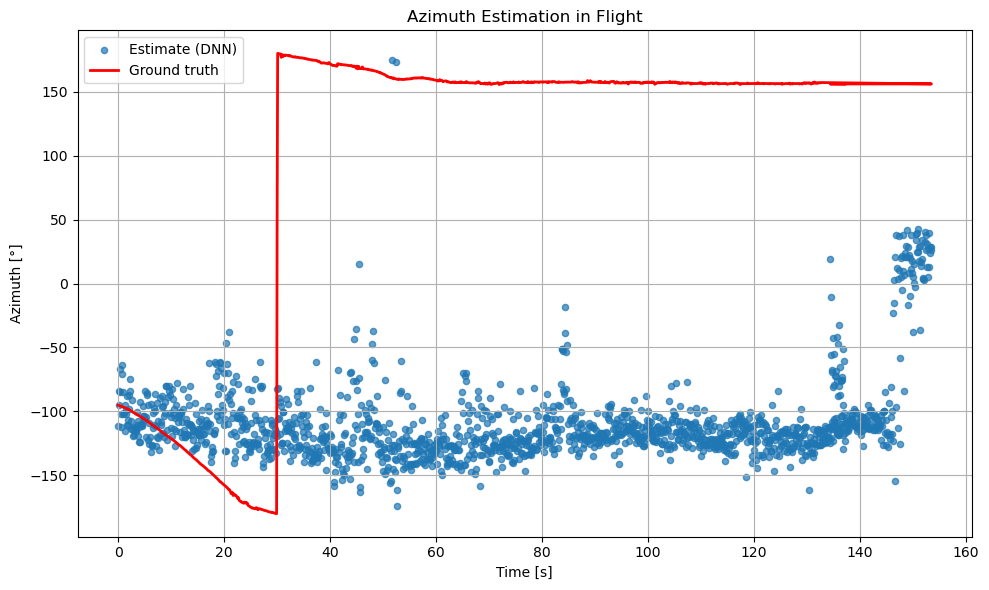

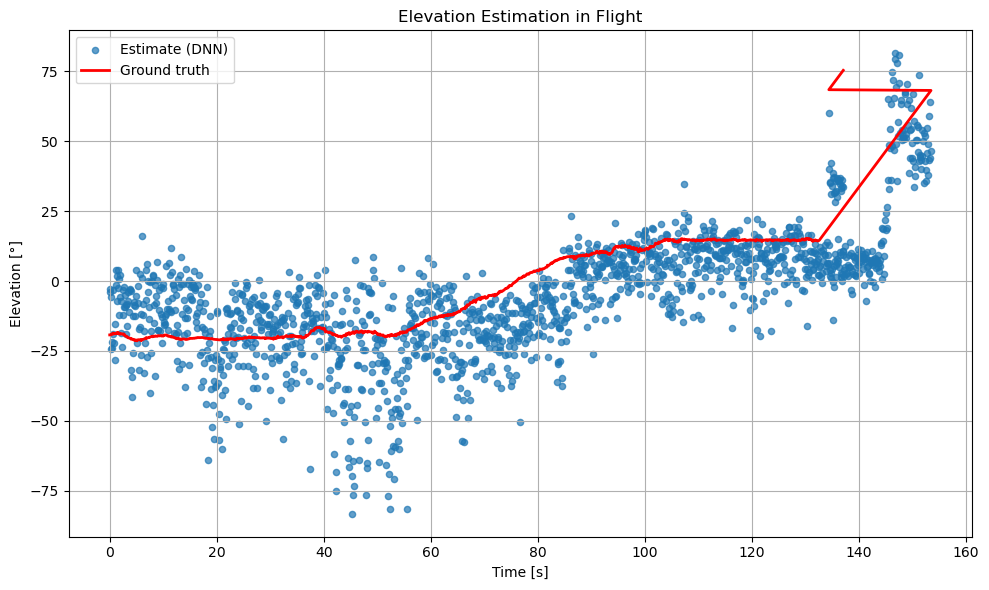

3D prediction plotted as Azimuth and Elevation.


In [57]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Evaluation ---

model.eval()
preds = []
targets = []
timestamps = []

with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_loader):
        x = x.to(device)  # Input shape: [B, C, Freq, Time]
        y = y.to(device)  # Ground truth: [B, 3]
        output = model(x)  # Output shape: [B, 3] (x, y, z)

        preds.append(output.cpu().numpy())
        targets.append(y.cpu().numpy())
        timestamps.append(np.arange(len(x)) + batch_idx * len(x))

# Stack all
preds = np.vstack(preds)        # shape: [N, 3]
targets = np.vstack(targets)    # shape: [N, 3]
timestamps = np.hstack(timestamps) * 0.1  # Time in seconds (adjust as needed)

# --- Convert to Azimuth & Elevation ---

def cartesian_to_angles(xyz):
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    azimuth = np.degrees(np.arctan2(y, x))
    elevation = np.degrees(np.arctan2(z, np.sqrt(x**2 + y**2)))
    return azimuth, elevation

pred_az, pred_el = cartesian_to_angles(preds)
true_az, true_el = cartesian_to_angles(targets)

# --- Plotting ---

# Azimuth plot
plt.figure(figsize=(10, 6))
plt.scatter(timestamps, pred_az, s=20, label='Estimate (DNN)', alpha=0.7)
plt.plot(timestamps, true_az, 'r-', linewidth=2, label='Ground truth')
plt.title('Azimuth Estimation in Flight')
plt.xlabel('Time [s]')
plt.ylabel('Azimuth [°]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Elevation plot
plt.figure(figsize=(10, 6))
plt.scatter(timestamps, pred_el, s=20, label='Estimate (DNN)', alpha=0.7)
plt.plot(timestamps, true_el, 'r-', linewidth=2, label='Ground truth')
plt.title('Elevation Estimation in Flight')
plt.xlabel('Time [s]')
plt.ylabel('Elevation [°]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("3D prediction plotted as Azimuth and Elevation.")
